# 저PER주 매수전략 백테스팅

References : https://capricorn8911.tistory.com/2

> 필요 데이터 : 2001년 1월 ~ 2019년 5월까지의 "월별" PER과 "월별" 주가데이터

- 주가 : price.xlsx
- PER : per.xlsx
- KOSPI200 : K200.xlsx

> 보통 백테스팅 시에는 "일별"이 아닌 "월별"로 백테스팅하는 것이 일반적임.

## 전략 : 매년 2, 5, 8, 11월마다 KOSPI200 상장기업의 중 PER이 낮은 30종목을 투자한다. 해당 포트폴리오의 누적수익률과, KOSPI200(벤치마크)의 누적수익률의 추이를 확인하고자 한다.



## 1. 모든 종목의 월별 PER 데이터 불러오기 & 시계열 형태로 변환하기

In [1]:
import numpy as np
import pandas as pd

df_per = pd.read_excel('per.xlsx')

df_per.head() # default : 5

,Date,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,...,A300720,A306200,A307950,A316140,A900030,A900050,A900140,A950010,A950070,A950100
0,2001-01-31,5.72,10.10,1.25,NaN,NaN,5.92,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-02-28,5.01,10.19,1.13,NaN,NaN,4.28,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001-03-30,3.57,7.24,1.14,NaN,4.66,3.71,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-04-30,4.18,7.77,1.10,NaN,6.76,2.86,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-05-31,5.21,9.81,1.02,NaN,7.05,3.71,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# pandas의 데이터프레임에서의 행 이름 : 인덱스(index) / 열 이름 : 칼럼(column)

# 작업 편리성을 위해 데이터프레임의 인덱스(행)를 "Date" 열로 변경함.
df_per.set_index("Date", inplace = True) # 새로 변수를 지정하지 않고 덮어씀(2번 동시 실행 시 오류 발생)
df_per.head()

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A300720,A306200,A307950,A316140,A900030,A900050,A900140,A950010,A950070,A950100
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-31,5.72,10.10,1.25,NaN,NaN,5.92,NaN,NaN,NaN,9.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-28,5.01,10.19,1.13,NaN,NaN,4.28,NaN,NaN,NaN,8.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-30,3.57,7.24,1.14,NaN,4.66,3.71,NaN,NaN,NaN,7.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-30,4.18,7.77,1.10,NaN,6.76,2.86,NaN,NaN,NaN,6.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,5.21,9.81,1.02,NaN,7.05,3.71,NaN,NaN,NaN,7.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_per.index

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-30', '2001-04-30',
               '2001-05-31', '2001-06-29', '2001-07-31', '2001-08-31',
               '2001-09-28', '2001-10-31',
               ...
               '2018-08-31', '2018-09-28', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-29',
               '2019-04-30', '2019-05-29'],
              dtype='datetime64[ns]', name='Date', length=221, freq=None)

## 2. 종목을 선정할 주기에 따라 날짜 생성 (매년 2, 5, 8, 11월 말)

> Q. 왜 3, 6, 9, 12월말이 아닌가? <br>
> 
> A. 12, 3, 6, 9월에 발표되는 모든 기업들의 실적 데이터가 모두 집계되었다고 가정하면, 3월에 발표되는 1분기 실적은 5월말에나 되어서야 집계가 가능할 것. 따라서 해당 시점에서 리밸런싱을 진행해야 더 많은 정보를 활용할 수 있으며 벡테스팅 시 각 시점마다 그 당시 사용가능했을 데이터만을 활용해서 성과를 확인할 수 있는 장점이 있음.

In [4]:
# df_per.index의 첫 번째 값이 "2001-01-31"(1월 말)이기 때문에
# 두 번째인 2월부터 시작해서 그 다음 3달마다의 값을 저장하도록 하는 코드(슬라이싱)
rebalancing_schedule = df_per[1 : : 3].index
rebalancing_schedule

DatetimeIndex(['2001-02-28', '2001-05-31', '2001-08-31', '2001-11-30',
               '2002-02-28', '2002-05-31', '2002-08-30', '2002-11-29',
               '2003-02-28', '2003-05-30', '2003-08-29', '2003-11-28',
               '2004-02-27', '2004-05-31', '2004-08-31', '2004-11-30',
               '2005-02-28', '2005-05-31', '2005-08-31', '2005-11-30',
               '2006-02-28', '2006-05-31', '2006-08-31', '2006-11-30',
               '2007-02-28', '2007-05-31', '2007-08-31', '2007-11-30',
               '2008-02-29', '2008-05-30', '2008-08-29', '2008-11-28',
               '2009-02-27', '2009-05-29', '2009-08-31', '2009-11-30',
               '2010-02-26', '2010-05-31', '2010-08-31', '2010-11-30',
               '2011-02-28', '2011-05-31', '2011-08-31', '2011-11-30',
               '2012-02-29', '2012-05-31', '2012-08-31', '2012-11-30',
               '2013-02-28', '2013-05-31', '2013-08-30', '2013-11-29',
               '2014-02-28', '2014-05-30', '2014-08-29', '2014-11-28',
      

## 3. KOSPI200 포함 여부 데이터 불러오기
-> 매 리밸런싱 날짜(rebalancing_schedule)마다의 데이터를 불러와서 저PER 30종목을 추리면 된다.

- 주의사항 : 전략의 벤치마크(비교대상)은 KOSPI200 지수이기 떄문에, 저PER 30종목 또한 해당 시점마다 KOSPI200 지수에 포함되어 있었던 종목들 중에서 골라내야 한다. 따라서 매월말 기준으로 각 종목들이 KOSPI200 지수에 포함돼있는지를 알 수 있는 데이터를 하나 더 불러온다.

In [5]:
# 파일 로드 시점에 첫 번째 열인 날짜 열이 df의 인덱스가 되도록 index_col = 0 옵션 추가
df_k200 = pd.read_excel("K200.xlsx", sheet_name = "K200", index_col = 0)
df_k200.head()

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A300720,A306200,A307950,A316140,A900030,A900050,A900140,A950010,A950070,A950100
1999-01-29,1,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1999-02-26,1,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1999-03-31,1,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1999-04-30,1,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1999-05-31,1,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 4. 첫 번째 날 기준으로 PER이 낮은 30개의 종목 추려내기
-> 특정 시점(첫 번째 날)을 하나 정해서, 그 시점에 1) KOSPI200 지수에 포함된 종목이고 2) 저PER인 30개의 종목을 필터링

In [6]:
first_date = rebalancing_schedule[0] # 리밸런싱 첫 번째 날짜
print(first_date, "=> KOSPI200 low PBR stocks list\n")

k200 = df_k200.loc[first_date, :] # 리밸런싱 첫 번째 날짜의 각 종목별 코스피200 포함여부 데이터화
k200_KOSPI = k200[k200 == 1].index.values # 값이 1(포함)인 종목코드만 따로 저장

per_i = df_per.loc[first_date, k200_KOSPI] # 코스피200에 포함되어 있으면서, 리밸런싱 첫 번째 날짜에 해당하는 PER 데이터로 저장
# 이상치 및 결측치 처리
per_i = per_i[per_i >= 0] # PER이 음수 == 실적이 음수라는 말이기 떄문에 포트폴리오에 포함시키지 않기로 함(이상치)
per_i = per_i.dropna() # 데이터가 없는 종목 제외(결측치)
per_i = per_i.astype(float)
low30 = per_i.nsmallest(30).index.values # 저PER 30종목 압축하여 저장
print(low30)

df_code = pd.DataFrame(low30, columns = ['code'])
df_code['date'] = first_date
df_code['weight'] = np.ones(len(df_code)) / len(df_code) # 1. / 30 = 0.03333...
print(df_code)
df_code = df_code[['date', 'code', 'weight']]
print(df_code)

2001-02-28 00:00:00 => KOSPI200 low PBR stocks list

['A000700' 'A001440' 'A025830' 'A011200' 'A003030' 'A030210' 'A006360'
 'A005950' 'A025000' 'A002300' 'A020000' 'A001740' 'A003300' 'A001800'
 'A017300' 'A009720' 'A012630' 'A006260' 'A010620' 'A012330' 'A012200'
 'A000150' 'A000210' 'A025850' 'A001680' 'A004150' 'A009280' 'A007310'
 'A018880' 'A001300']
       code       date    weight
0   A000700 2001-02-28  0.033333
1   A001440 2001-02-28  0.033333
2   A025830 2001-02-28  0.033333
3   A011200 2001-02-28  0.033333
4   A003030 2001-02-28  0.033333
5   A030210 2001-02-28  0.033333
6   A006360 2001-02-28  0.033333
7   A005950 2001-02-28  0.033333
8   A025000 2001-02-28  0.033333
9   A002300 2001-02-28  0.033333
10  A020000 2001-02-28  0.033333
11  A001740 2001-02-28  0.033333
12  A003300 2001-02-28  0.033333
13  A001800 2001-02-28  0.033333
14  A017300 2001-02-28  0.033333
15  A009720 2001-02-28  0.033333
16  A012630 2001-02-28  0.033333
17  A006260 2001-02-28  0.033333
18  A010620 20

## 5. for문을 이용하여 모든 종목 선정일마다 30개의 저PER주를 추려 저장

-> 앞선 과정을 "매 리밸런싱 시점마다의" 30개의 저PER주를 추려내어 저장하는 작업을 수행

1) for loop
2) 매 날짜마다 새로운 종목이 쌓여 저장됨
3) 해당 시점마다 각 종목들에 투자 비중이 부여되어, 데이터프레임의 형태로 저장됨

In [7]:
rebalData_all = []

for i in range(len(rebalancing_schedule)):

    rebal_date = rebalancing_schedule[i]
    k200 = df_k200.loc[rebal_date, :]
    k200 = k200[k200 == 1].index.values

    per_ith = df_per.loc[rebal_date, k200] # 코스피200에 포함되어 있으면서, 'i'번째 리밸런싱 날짜에 해당하는 PER 데이터로 저장
    per_ith = per_ith[per_ith >= 0]
    per_ith = per_ith.dropna()
    per_ith = per_ith.astype(float)
    low30 = per_ith.nsmallest(30).index.values

    df_code = pd.DataFrame(low30, columns = ["code"]) # code 열에 종목코드 매핑
    df_code["date"] = rebal_date # date 열에 'i'번째 리밸런싱 날짜 매핑
    df_code["weight"] = np.ones(len(df_code)) / len(df_code)
    df_code = df_code[["date", "code", "weight"]]

    rebalData_all.append(df_code)

# - - - 기존 방법 - - -
# rebalData_all = pd.concat(rebalData_all)
# print(rebalData_all)
# rebalData_all.set_index("date", inplace = True)
# print(rebalData_all)
# - - - - - - - - - -

rebalData_all = pd.concat(rebalData_all, ignore_index = True)
print(rebalData_all)

           date     code    weight
0    2001-02-28  A000700  0.033333
1    2001-02-28  A001440  0.033333
2    2001-02-28  A025830  0.033333
3    2001-02-28  A011200  0.033333
4    2001-02-28  A003030  0.033333
...         ...      ...       ...
2215 2019-05-29  A011170  0.033333
2216 2019-05-29  A001450  0.033333
2217 2019-05-29  A003550  0.033333
2218 2019-05-29  A071050  0.033333
2219 2019-05-29  A009830  0.033333

[2220 rows x 3 columns]


## 6. 종가 데이터를 활용하여 전략의 성과 확인
-> 5에서 만든 매 시점마다의 저PER주 데이터를 활용하여, 해당 시점에 동일비중으로 투자했을 때의 누적 성과를 확인

In [8]:
# 종가 데이터 불러오기
priceData = pd.read_excel('price.xlsx', index_col = 0)
priceData

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A300720,A306200,A307950,A316140,A900030,A900050,A900140,A950010,A950070,A950100
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,3195.0,2720,2915.0,9890,1752,875,13717,4050.0,NaN,15181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,2360.0,2814,2000.0,8991,1781,743,16310,4050.0,NaN,18046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,2005.0,2973,1730.0,9590,2127,680,13285,3430.0,NaN,17091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-28,2040.0,2215,1685.0,9290,1856,451,14257,3000.0,NaN,14527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,2605.0,1751,1895.0,7417,1687,468,10531,3100.0,NaN,14980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-31,NaN,9840,14800.0,528,11000,22200,83200,16900.0,NaN,238000,...,142000.0,66900.0,NaN,NaN,NaN,NaN,2715.0,NaN,NaN,NaN
2019-02-28,NaN,9800,NaN,507,11250,22100,84300,17700.0,NaN,260500,...,143000.0,64500.0,NaN,14800.0,NaN,NaN,2820.0,NaN,NaN,NaN
2019-03-29,NaN,9400,NaN,493,10050,24300,82500,18500.0,NaN,240000,...,144500.0,62200.0,82100.0,13750.0,NaN,NaN,2565.0,NaN,NaN,NaN


> 리밸런싱 구간 사이의 성과를 구해야 하기 때문에, 불러온 종가 데이터를 리밸런싱 시점의 데이터로 압축하여, 전 기 대비 변화율 데이터로 변환한다.

In [9]:
rebal_price = priceData.loc[rebalancing_schedule, :] # 주가 데이터에서 리밸런싱 날짜에 해당하는 값만 추출
rebal_price

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A300720,A306200,A307950,A316140,A900030,A900050,A900140,A950010,A950070,A950100
Date,,,,,,,,,,,,,,,,,,,,,
2001-02-28,2545.0,1661,865.0,7792,1889,316,11557,3100.0,NaN,22286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,2685.0,1926,865.0,9141,1817,558,15553,4000.0,NaN,25596,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-31,2220.0,1500,865.0,9740,1593,413,14219,3600.0,NaN,34036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-11-30,3330.0,1940,865.0,7792,1608,646,16533,3330.0,NaN,34146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-28,5720.0,2040,865.0,4600,1860,1393,27445,3500.0,NaN,34856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31,NaN,11450,15300.0,722,13050,20500,114500,20150.0,NaN,227746,...,NaN,NaN,NaN,NaN,NaN,NaN,4311.0,NaN,NaN,NaN
2018-08-31,NaN,11600,16300.0,587,13750,18250,102000,16800.0,NaN,228703,...,151500.0,NaN,NaN,NaN,NaN,NaN,3716.0,NaN,NaN,NaN
2018-11-30,NaN,9110,15650.0,512,11250,21200,87500,17500.0,NaN,217698,...,132000.0,62700.0,NaN,NaN,NaN,NaN,2329.0,NaN,NaN,NaN


In [10]:
df_return = rebal_price.pct_change() # 수익률 데이터로 변환을 수행해주는 함수(퍼센테이지 변환)
df_return # 리밸런싱 첫 번째 일자인 2001-02-28은 모든 종목의 수익률이 NaN인게 정상임. (다음 행 - 현재 행) / 현재 행의 값을 계산

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A300720,A306200,A307950,A316140,A900030,A900050,A900140,A950010,A950070,A950100
Date,,,,,,,,,,,,,,,,,,,,,
2001-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,0.055010,0.159542,0.000000,0.173126,-0.038115,0.765823,0.345764,0.290323,NaN,0.148524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-31,-0.173184,-0.221184,0.000000,0.065529,-0.123280,-0.259857,-0.085771,-0.100000,NaN,0.329739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-11-30,0.500000,0.293333,0.000000,-0.200000,0.009416,0.564165,0.162740,-0.075000,NaN,0.003232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-28,0.717718,0.051546,0.000000,-0.409651,0.156716,1.156347,0.660013,0.051051,NaN,0.020793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31,0.000000,0.004386,-0.078313,0.286988,-0.071174,-0.102845,0.026906,-0.084091,NaN,0.144234,...,NaN,NaN,NaN,NaN,0.0,0.0,-0.017100,0.0,0.0,0.0
2018-08-31,0.000000,0.013100,0.065359,-0.186981,0.053640,-0.109756,-0.109170,-0.166253,NaN,0.004202,...,NaN,NaN,NaN,NaN,0.0,0.0,-0.138019,0.0,0.0,0.0
2018-11-30,0.000000,-0.214655,-0.039877,-0.127768,-0.181818,0.161644,-0.142157,0.041667,NaN,-0.048119,...,-0.128713,NaN,NaN,NaN,0.0,0.0,-0.373251,0.0,0.0,0.0


### **!!!중요!!!** : 2001-05-31(5월말) 기준 '수익률'은 2001-02-28(2월말) 기준 종목데이터와 매칭시켜야 하기 때문에, 데이터를 한 줄씩 앞으로 당겨주어야 한다.

In [11]:
df_return = df_return.shift(-1)
df_return

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A300720,A306200,A307950,A316140,A900030,A900050,A900140,A950010,A950070,A950100
Date,,,,,,,,,,,,,,,,,,,,,
2001-02-28,0.055010,0.159542,0.000000,0.173126,-0.038115,0.765823,0.345764,0.290323,NaN,0.148524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,-0.173184,-0.221184,0.000000,0.065529,-0.123280,-0.259857,-0.085771,-0.100000,NaN,0.329739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-31,0.500000,0.293333,0.000000,-0.200000,0.009416,0.564165,0.162740,-0.075000,NaN,0.003232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-11-30,0.717718,0.051546,0.000000,-0.409651,0.156716,1.156347,0.660013,0.051051,NaN,0.020793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-28,0.066434,-0.219608,0.000000,0.024565,0.052151,-0.150036,-0.255019,0.114286,NaN,-0.029866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31,0.000000,0.013100,0.065359,-0.186981,0.053640,-0.109756,-0.109170,-0.166253,NaN,0.004202,...,NaN,NaN,NaN,NaN,0.0,0.0,-0.138019,0.0,0.0,0.0
2018-08-31,0.000000,-0.214655,-0.039877,-0.127768,-0.181818,0.161644,-0.142157,0.041667,NaN,-0.048119,...,-0.128713,NaN,NaN,NaN,0.0,0.0,-0.373251,0.0,0.0,0.0
2018-11-30,0.000000,0.075741,0.000000,-0.009766,0.000000,0.042453,-0.036571,0.011429,NaN,0.196612,...,0.083333,0.028708,NaN,NaN,0.0,0.0,0.210820,0.0,0.0,0.0


In [12]:
# 분기별 저PER주 데이터의 수익률만을 필터링하여 평균을 계산한 후 누적한다.
return_quarterly = []

for i in range(len(rebalancing_schedule)):
    rebal_date = rebalancing_schedule[i]
    firms = rebalData_all[rebalData_all["date"] == rebal_date]["code"].values # 해당 리밸런싱 일자에만 해당하는 종목코드
    basket = df_return.loc[rebal_date, firms] # 해당 리밸런싱 일자의 수익률 데이터 중 뽑힌 종목코드 데이터만 불러오기
    basket_return = basket.mean() # 수익률의 평균 계산 (equal-weighted)
    return_quarterly.append(basket_return) # 수익률 리스트에 append

# 리밸런싱 일자를 인덱스로 하는 데이터프레임화
return_quarterly = pd.DataFrame(return_quarterly, index = rebalancing_schedule, columns = ["return"])

# 수익률의 "실현"은 그 다음 리밸런싱 일자이기 때문에, 한 칸씩 다시 뒤로 미룸
return_quarterly = return_quarterly.shift(1)

### 매 분기 별 저PER 전략의 수익률 도출 완료(return_quarterly). 해당 전략으로 꾸준히 투자했을 경우의 누적 수익률을 계산해보고 차트로 시각화한다.

In [13]:
print(return_quarterly)

              return
Date                
2001-02-28       NaN
2001-05-31  0.187172
2001-08-31 -0.100842
2001-11-30  0.232404
2002-02-28  0.440953
...              ...
2018-05-31 -0.011295
2018-08-31 -0.059145
2018-11-30 -0.081826
2019-02-28  0.063575
2019-05-29 -0.068911

[74 rows x 1 columns]


### 의문사항 QnA

1. fillna(0)의 사용 목적은 2001-02-28 날짜의 수익률이 NaN (Not a Number, 결측치)으로 되어 있을 때, 이를 0으로 채워 넣는 것입니다. 이는 일반적으로 시계열 데이터에서 발생할 수 있는 결측치를 처리하기 위한 방법 중 하나입니다. 이 경우에는 2001-02-28 날짜의 수익률이 기록되지 않은 경우가 있을 수 있으며, 그것을 0으로 가정하고 시작하는 것입니다.

2. 일반 수익률은 각 기간별 수익률을 말합니다. 예를 들어, 2001-05-31의 수익률은 0.187172입니다. 반면 누적 수익률은 특정 시점부터 현재까지의 모든 기간을 합한 누적 수익률을 의미합니다. 즉, 이전 기간까지의 수익률을 모두 곱해 나간 값입니다. 누적 수익률을 구할 때는 이전 기간의 수익률 정보가 필요하므로, 첫 번째 기간(예: 2001-02-28)의 수익률이 0으로 채워져 있어도 시작할 수 있습니다.

<Axes: xlabel='Date'>

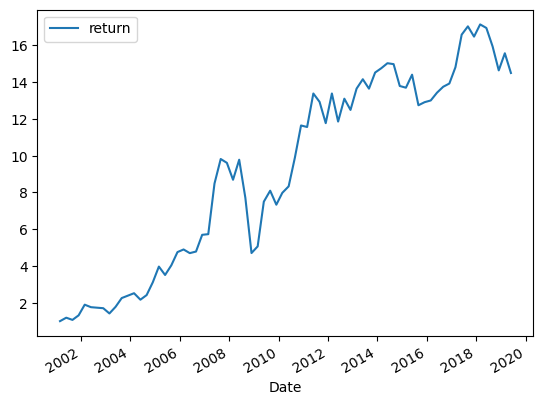

In [16]:
cumulative_return_quarterly = (return_quarterly.fillna(0) + 1).cumprod() # cumulative product(누적곱)
cumulative_return_quarterly.plot() # 차트 그리기
# (y축 수치 x 100)% 의 누적수익률을 의미함. ex) 2019년 5월까지의 누적수익률 약 1400% 상회

### 벤치마크인 KOSPI200 대비 초과수익률 보여주는 그래프

<Axes: xlabel='Date'>

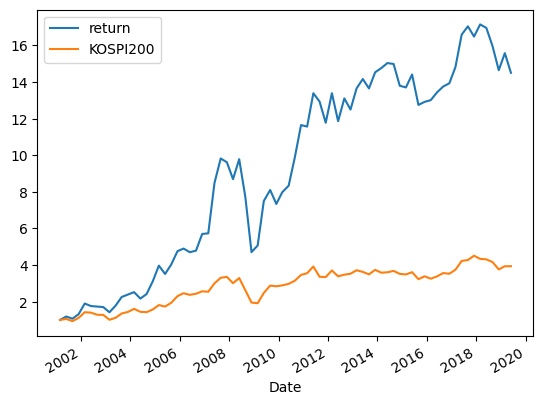

In [19]:
k200_p = pd.read_excel("K200.xlsx", sheet_name = "index_price", index_col = 0)
k200_p.columns = ["KOSPI200"]

k200_p = k200_p.reindex(rebalancing_schedule) # 리밸런싱 주기와 일치하는 시점의 데이터만으로 추려냄
cumreturn_k200 = (k200_p.pct_change().fillna(0) + 1).cumprod() # KOSPI200 지수의 누적수익률 계산
results = pd.concat([cumulative_return_quarterly, cumreturn_k200], axis = 1) # 전략의 누적 수익률과 데이터 결합

results.plot()